In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from brick.azr import AZR
from iminuit import Minuit

from tqdm import tqdm

# Minuit variables
iter   = 0
scale   = 1

# Define the data labels (in AZURE2 order)
labels = ["Meyer et al. (1976) - 84.3 deg",
          "Meyer et al. (1976) - 114.5 deg",
          "Meyer et al. (1976) - 144.1 deg", 
          "LUNA HPGe (2023)", 
          "LUNA BGO (2023)", 
          "Felsenkeller (2023)", 
          "Notre Dame (2023) - 0 deg",
          "Notre Dame (2023) - 55 deg"]

# Nuisance parameter map : { index : (value, error) } (in AZURE2 order)
nuisances = { 0 : (1.63, 0.12), 13: (1, 0.05), 14: (1, 0.05),  15: (1, 0.05),  16: (1, 0.069),  17: (1, 0.079),  18: (1, 0.1),  19: (1, 0.1),  20: (1, 0.1) }

In [2]:
# Convert the covariance matrix into a correlation matrix
def corr_from_cov(cov):
    v = np.sqrt(np.diag(cov))
    outer_v = np.outer(v, v)
    corr = cov / outer_v
    corr[cov == 0] = 0
    return corr

In [3]:
# We read the .azr file and set the external capture file to speed up the calculation
azr = AZR('12c_pg.azr')
azr.ext_capture_file ='output/intEC.dat'

# We get the initial values from AZURE2
theta0  = azr.config.get_input_values()
ntheta  = len(theta0)
nparams = len(azr.config.parameters)

In [4]:
# We'll read the data from the output file since it's already in the center-of-mass frame
data    = np.vstack([np.loadtxt('output/'+f) for f in azr.config.data.output_files])
x       = data[:, 0]
y       = data[:, 5]
dy_bare = data[:, 6]

In [5]:
# Add nuisance parameters to the fit
def add_nuisance(theta):
    chi2 = 0
    for i in nuisances: chi2 += pow((theta[i] - nuisances[i][0])/nuisances[i][1], 2)
    return chi2

# Chi2 function to minimize
def chi2(theta):
    global iter
    iter      += 1
    output     = np.vstack(azr.predict(theta, dress_up=False))
    mu, y, dy  = output[:, 3], output[:, 5], output[:, 6]
    chi2       = np.sum(pow((y - mu)/(dy*scale),2))
    chi2      += add_nuisance(theta)
    print( "Iteration: {:6d} it Chi2: {:15.4f}".format( iter, chi2 ), end="\r" )
    return chi2

chi2.errordef = Minuit.LEAST_SQUARES
chi2.ndata    = len(x)

In [6]:
# We set up the Minuit2
m = Minuit( chi2, theta0 )

# Configuration of Minuit2
m.tol = 1000
m.strategy = 2

# Adding limits for the level energies and ANC (in order not to break AZURE2)
for idx in range( len( azr.config.labels ) ):
    if( "$E_" in azr.config.labels[idx] ): m.limits[idx] = (theta0[idx]-0.01,theta0[idx]+0.01)
    elif( "$C_" in azr.config.labels[idx] ):
        if( theta0[idx] > 0 ): m.limits[idx] = (theta0[idx]*0.1,theta0[idx]*10)
        else: m.limits[idx] = (theta0[idx]*10,theta0[idx]*0.1)
    elif( "$n_" in azr.config.labels[idx] ): m.limits[idx] = (0.1,10)

In [7]:
# First minimization leaving the normalization fixed
for idx in range( len( labels ) ): m.fixed[-idx-1] = True
m.migrad( )

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1814 (χ²/ndof = 5.0)       │             Nfcn = 2802              │
│ EDM = 1.84 (Goal: 2)             │           time = 344.5 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │  1.7949   │  0.0033   │            │            │  0.163  │  16.3   │       │
│ 1 │ x1   │  2.36851  │  0.00010  │            │            │ 2.3588  │ 2.3788  │       │
│ 2 │ x2   │ 35.770e3  │  0.017e3  │            │            │         │         │       │
│ 3 │ x3   │  -0.4383  │  0.0025   │            │            │         │         │       │
│ 4 │ x4   │  -0.79e3  │  0.15e3   │            │            │         │         │       │
│ 5 │ x5   │  3.50642  │  0.00017  │            │            │  3.495  │  3.515  │       │
│ 6 │ x6   │ 54.3216e3 │ 0.0029e3  │            │            │         │         │       │
│ 7 │ x7   │  -0.5813  │  0.0013   │            │            │         │         │       │
│ 8 │ x8   │  14.9e-3  │  0.9e-3   │            │            │         │         │       │
│ 9 │ x9   │  -0.18e3  │  0.21e3   │            │            │         │         │       │
│ 10│ x10  │    6e3    │    4e3    │            │            │         │         │       │
│ 11│ x11  │  3.54742  │  0.00031  │            │            │ 3.5362  │ 3.5562  │       │
│ 12│ x12  │  47.08e3  │  0.18e3   │            │            │         │         │       │
│ 13│ x13  │   1.00    │   0.01    │            │            │   0.1   │   10    │  yes  │
│ 14│ x14  │   1.00    │   0.01    │            │            │   0.1   │   10    │  yes  │
│ 15│ x15  │   1.00    │   0.01    │            │            │   0.1   │   10    │  yes  │
│ 16│ x16  │   1.00    │   0.01    │            │            │   0.1   │   10    │  yes  │
│ 17│ x17  │   1.00    │   0.01    │            │            │   0.1   │   10    │  yes  │
│ 18│ x18  │   1.00    │   0.01    │            │            │   0.1   │   10    │  yes  │
│ 19│ x19  │   1.00    │   0.01    │            │            │   0.1   │   10    │  yes  │
│ 20│ x20  │   1.00    │   0.01    │            │            │   0.1   │   10    │  yes  │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│     │             x0             x1             x2             x3             x4             x5             x6             x7             x8             x9            x10            x11            x12            x13            x14            x15            x16            x17            x18            x19            x20 │
├─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [8]:
# Second minimization leaving the normalization free
for idx in range( len( labels ) ): m.fixed[-idx-1] = False
m.migrad( )

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1525 (χ²/ndof = 4.3)       │             Nfcn = 7765              │
│ EDM = 0.157 (Goal: 2)            │           time = 162.5 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           ABOVE call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│           Hesse FAILED           │           ABOVE call limit           │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │  1.8029   │  0.0000   │            │            │  0.163  │  16.3   │       │
│ 1 │ x1   │  2.3683   │  0.0000   │            │            │ 2.3588  │ 2.3788  │       │
│ 2 │ x2   │ 3.5956e4  │ 0.0000e4  │            │            │         │         │       │
│ 3 │ x3   │-4.5871e-1 │ 0.0000e-1 │            │            │         │         │       │
│ 4 │ x4   │ -4.7596e1 │ 0.0000e1  │            │            │         │         │       │
│ 5 │ x5   │  3.5065   │  0.0000   │            │            │  3.495  │  3.515  │       │
│ 6 │ x6   │ 5.4447e4  │ 0.0000e4  │            │            │         │         │       │
│ 7 │ x7   │-5.2217e-1 │ 0.0000e-1 │            │            │         │         │       │
│ 8 │ x8   │ 5.9568e-4 │ 0.0000e-4 │            │            │         │         │       │
│ 9 │ x9   │ -1.7397e2 │ 0.0000e2  │            │            │         │         │       │
│ 10│ x10  │ -9.1534e2 │ 0.0000e2  │            │            │         │         │       │
│ 11│ x11  │  3.5475   │  0.0000   │            │            │ 3.5362  │ 3.5562  │       │
│ 12│ x12  │ 4.6959e4  │ 0.0000e4  │            │            │         │         │       │
│ 13│ x13  │  1.0204   │  0.0000   │            │            │   0.1   │   10    │       │
│ 14│ x14  │  1.0126   │  0.0000   │            │            │   0.1   │   10    │       │
│ 15│ x15  │  1.0056   │  0.0000   │            │            │   0.1   │   10    │       │
│ 16│ x16  │  1.0506   │  0.0000   │            │            │   0.1   │   10    │       │
│ 17│ x17  │  1.0448   │  0.0000   │            │            │   0.1   │   10    │       │
│ 18│ x18  │  1.0545   │  0.0000   │            │            │   0.1   │   10    │       │
│ 19│ x19  │  1.2591   │  0.0000   │            │            │   0.1   │   10    │       │
│ 20│ x20  │ 8.815e-1  │ 0.000e-1  │            │            │   0.1   │   10    │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [9]:
# Now we scale the errors in order to get chi2/ndf = 1 for proper uncertainty estimation
scale  = np.sqrt( m.fval / ( len(x) - nparams ) )
m.tol *= scale
m.hesse( )

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1525 (χ²/ndof = 4.3)       │             Nfcn = 8164              │
│ EDM = 23.9 (Goal: 2)             │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   1.80    │   0.12    │            │            │  0.163  │  16.3   │       │
│ 1 │ x1   │  2.36827  │  0.00014  │            │            │ 2.3588  │ 2.3788  │       │
│ 2 │ x2   │  35.96e3  │  0.33e3   │            │            │         │         │       │
│ 3 │ x3   │  -0.459   │   0.005   │            │            │         │         │       │
│ 4 │ x4   │  -0.05e3  │  0.10e3   │            │            │         │         │       │
│ 5 │ x5   │  3.50648  │  0.00027  │            │            │  3.495  │  3.515  │       │
│ 6 │ x6   │  54.4e3   │   0.9e3   │            │            │         │         │       │
│ 7 │ x7   │  -0.522   │   0.008   │            │            │         │         │       │
│ 8 │ x8   │  0.6e-3   │  0.4e-3   │            │            │         │         │       │
│ 9 │ x9   │  -0.17e3  │  0.12e3   │            │            │         │         │       │
│ 10│ x10  │  -0.9e3   │   0.7e3   │            │            │         │         │       │
│ 11│ x11  │  3.5475   │  0.0004   │            │            │ 3.5362  │ 3.5562  │       │
│ 12│ x12  │  47.0e3   │   0.9e3   │            │            │         │         │       │
│ 13│ x13  │   1.02    │   0.01    │            │            │   0.1   │   10    │       │
│ 14│ x14  │   1.013   │   0.009   │            │            │   0.1   │   10    │       │
│ 15│ x15  │   1.006   │   0.006   │            │            │   0.1   │   10    │       │
│ 16│ x16  │   1.051   │   0.019   │            │            │   0.1   │   10    │       │
│ 17│ x17  │   1.045   │   0.020   │            │            │   0.1   │   10    │       │
│ 18│ x18  │   1.054   │   0.011   │            │            │   0.1   │   10    │       │
│ 19│ x19  │   1.26    │   0.08    │            │            │   0.1   │   10    │       │
│ 20│ x20  │   0.882   │   0.024   │            │            │   0.1   │   10    │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│     │           x0           x1           x2           x3           x4           x5           x6           x7           x8           x9          x10          x11          x12          x13          x14          x15          x16          x17          x18          x19          x20 │
├─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [10]:
# Saving best fit values
best, err = m.values, m.errors
np.savetxt( "minuit/best_chi2.txt", np.transpose([best,err]), fmt='%1.4e %1.4e' )

# Savin the covariance if it exists
if( m.covariance is not None ):
    
    # Get the covariance from minuit
    table = m.covariance.to_table( )[0]
    cov = np.empty( shape=(len(table),len(table)) )
    for idx in range( len( table ) ):
        cov[idx] = np.asarray( table[idx][1:] )
    np.savetxt( "minuit/covariance_chi2.txt", cov, fmt='%1.4e' )

else: cov = None

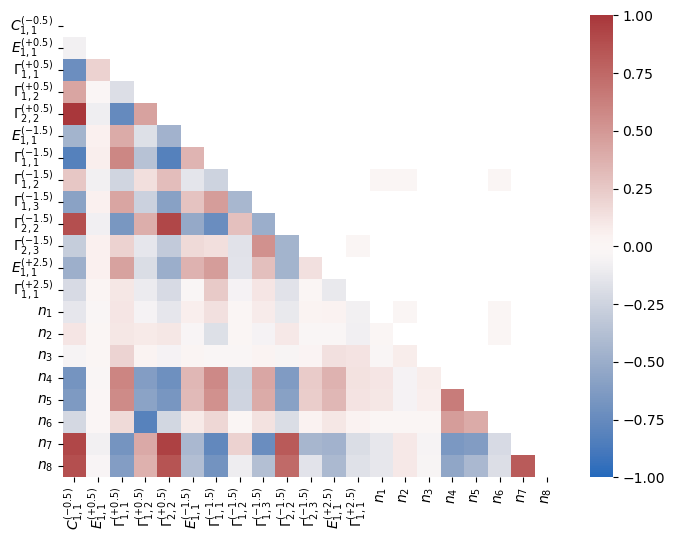

In [11]:
if( cov is not None ):

    # Calculate the correlation matrix
    corr = corr_from_cov(cov)
    mask = np.triu( corr )

    # Plot the correlation heatmap
    plt.figure(figsize=(8, 6))
    colormap = sns.color_palette("vlag", as_cmap=True)
    sns.heatmap( corr, vmin=-1, vmax=1, cmap=colormap, center=0, annot=False, fmt=".2f", mask=mask, xticklabels=azr.config.labels, yticklabels=azr.config.labels )

In [12]:
# All the data are in a single array, so we need to split them up
segments = azr.config.data.segments
lenghts = np.empty( shape=(len(segments)-1), dtype=int )
for idx, segment in enumerate(segments):
    if( idx == (len(segments) - 1) ): continue
    lenghts[idx] = len( segment.values )

x_split = np.split( x, np.cumsum(lenghts) )
y_split = np.split( y, np.cumsum(lenghts) )
dy_split = np.split( dy_bare, np.cumsum(lenghts) )

In [13]:
# Number of samples
nsamples = 1000

# Sample the covariance matrix
samples = np.random.multivariate_normal( m.values, cov, nsamples )

# Calculate the S-factor for each sample
bucket = {}
for i in tqdm( range( nsamples ) ):
    output = np.vstack(azr.predict(samples[i], dress_up=False))
    output = np.split( output, np.cumsum(lenghts) )
    for idx in range( len( output ) ):
        if( idx not in bucket ): bucket[idx] = []
        else: bucket[idx].append( output[idx] )

/var/folders/13/_3g2lmwx6xl3zshjv1d7yz4c0000gn/T/ipykernel_42684/3837538052.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal( m.values, cov, nsamples )
100%|██████████| 1000/1000 [01:15<00:00, 13.24it/s]


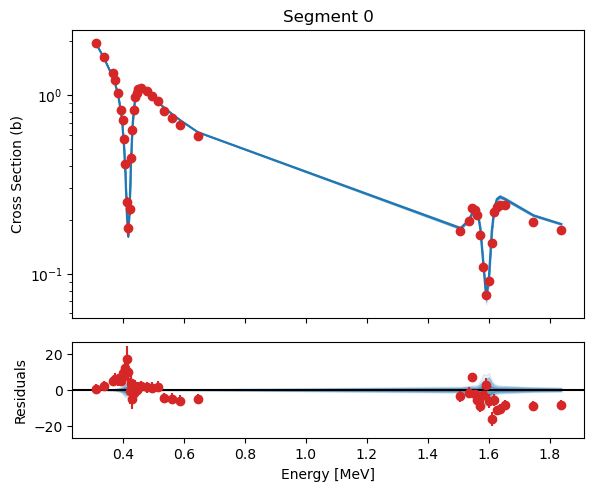

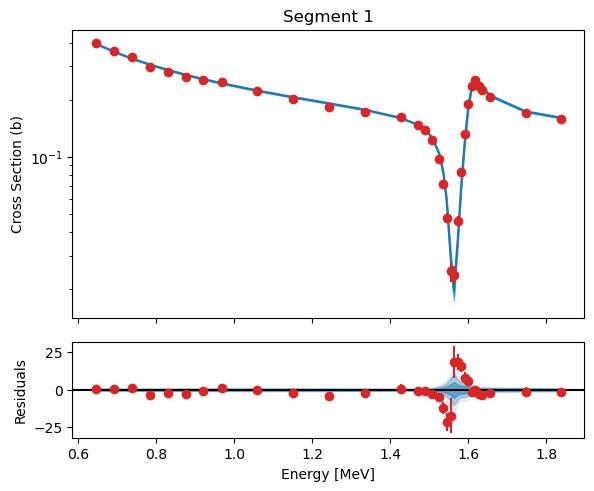

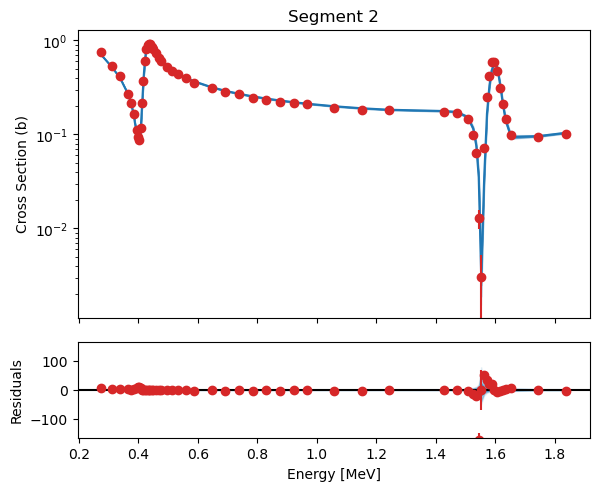

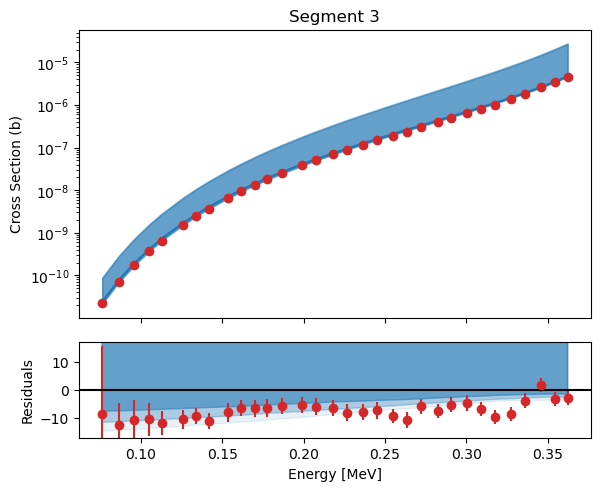

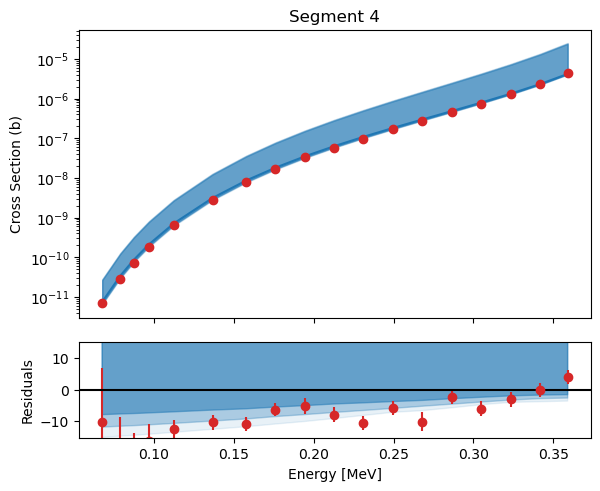

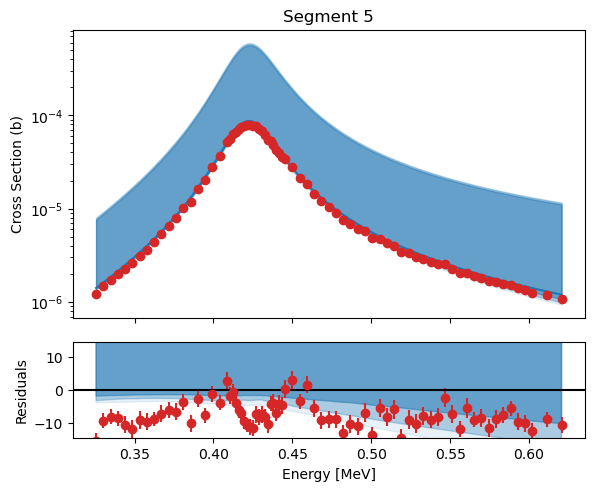

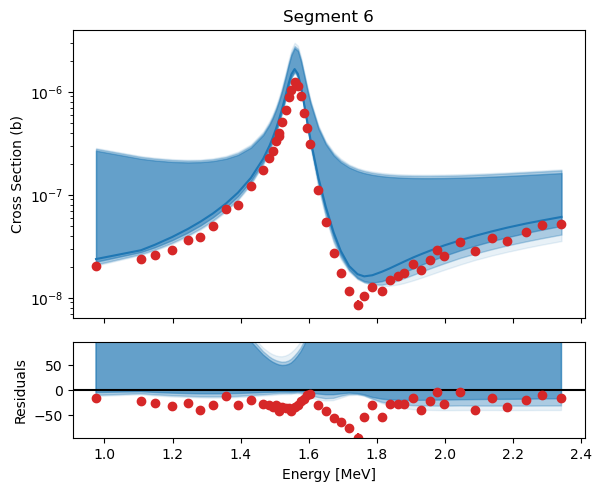

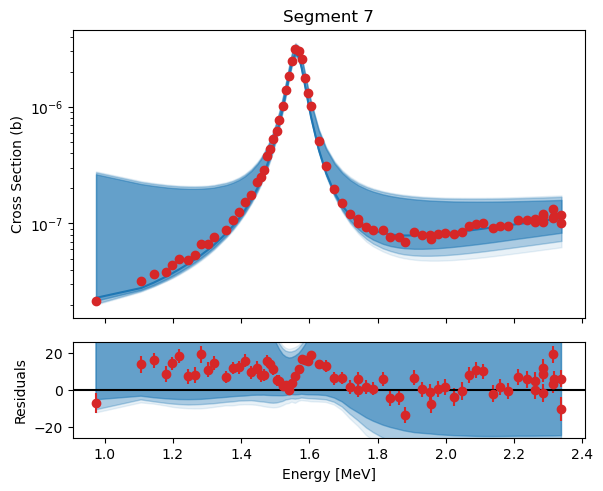

In [14]:
for i in range( len( segments ) ):

    # Now we plot the 1, 2 and 3 sigmas confidence intervals
    fig1 = plt.figure( )
    ax1 = fig1.add_axes((.1,.35,.8,.6))
    ax1.set_ylabel( "Cross Section (b)" )
    ax1.set_yscale( 'log' )
    ax1.set_xticklabels([])
    ax1.set_title( "Segment {}".format( i ) )

    bucket[i] = np.asarray( bucket[i] )

    quant_sigma1_low = np.zeros( len( x_split[i] ) )
    quant_sigma1_up  = np.zeros( len( x_split[i] ) )
    quant_sigma2_low = np.zeros( len( x_split[i] ) )
    quant_sigma2_up  = np.zeros( len( x_split[i] ) )
    quant_sigma3_low = np.zeros( len( x_split[i] ) )
    quant_sigma3_up  = np.zeros( len( x_split[i] ) )
    quant_mean       = np.zeros( len( x_split[i] ) )

    for j in range( len( x_split[i] ) ):
        quant_sigma1_low[j] = np.quantile( bucket[i][:,j,3], 0.158 )
        quant_sigma1_up[j]  = np.quantile( bucket[i][:,j,3], 0.841 )
        quant_sigma2_low[j] = np.quantile( bucket[i][:,j,3], 0.023 )
        quant_sigma2_up[j]  = np.quantile( bucket[i][:,j,3], 0.977 )
        quant_sigma3_low[j] = np.quantile( bucket[i][:,j,3], 0.002 )
        quant_sigma3_up[j]  = np.quantile( bucket[i][:,j,3], 0.998 )
        quant_mean[j]       = np.quantile( bucket[i][:,j,3], 0.5   )

    ax1.plot( x_split[i], quant_mean, color="tab:blue", label='Mean' )
    ax1.errorbar( x_split[i], y_split[i], yerr=dy_split[i], color="tab:red", fmt="o", label='{}'.format( labels[i] ) )
    ax1.fill_between( x_split[i], quant_sigma1_low, quant_sigma1_up, color="tab:blue", alpha=0.5, label='1 sigma' )
    ax1.fill_between( x_split[i], quant_sigma2_low, quant_sigma2_up, color="tab:blue", alpha=0.3, label='2 sigma' )
    ax1.fill_between( x_split[i], quant_sigma3_low, quant_sigma3_up, color="tab:blue", alpha=0.1, label='3 sigma' )

    percent = 100 * ( y_split[i] - quant_mean ) / y_split[i]
    percent_err = 100 * ( dy_split[i] / y_split[i] )
    max_percent = max( abs( percent + percent_err ) )

    ax2 = fig1.add_axes((.1,.1,.8,.2))
    ax2.errorbar( x_split[i], percent, yerr=percent_err, fmt="o", color="tab:red" )
    ax2.fill_between( x_split[i], 100 * ( quant_sigma1_low - quant_mean ) / quant_mean, 100 * ( quant_sigma1_up - quant_mean ) / quant_mean, color="tab:blue", alpha=0.5, label='1 sigma' )
    ax2.fill_between( x_split[i], 100 * ( quant_sigma2_low - quant_mean )/ quant_mean, 100 * ( quant_sigma2_up - quant_mean ) / quant_mean, color="tab:blue", alpha=0.3, label='2 sigma' )
    ax2.fill_between( x_split[i], 100 * ( quant_sigma3_low - quant_mean ) / quant_mean, 100 * ( quant_sigma3_up - quant_mean ) / quant_mean, color="tab:blue", alpha=0.1, label='3 sigma' )
    ax2.axhline( 0, color="black" )
    ax2.set_xlabel( "Energy [MeV]" )
    ax2.set_ylabel( "Residuals" )
    ax2.set_ylim( -max_percent * 1.1, max_percent * 1.1 )

plt.show( )